Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

In [202]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [219]:
# Most IMPORTantly

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import OneHotEncoder
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [204]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols, parse_dates= ['SALE DATE'], index_col= 'SALE DATE')

    # Change the datatype of BOROUGH
    df['BOROUGH'] = df['BOROUGH'].astype(object)

    # Extract $- from SALE PRICE
    df['SALE PRICE'] = df['SALE PRICE'].replace('[\$\,\.\-]', '', regex= True).astype(int)
    
    # Remove Rows that are not SINGLE FAMILY DWELLINGS and not in the price range
    df_select = df.loc[(df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE PRICE'] >= 100000) & (df['SALE PRICE'] <= 2000000)]

    return df_select

filepath = DATA_PATH +'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [205]:
df = wrangle(filepath)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
SALE DATE,,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1872.0,1940.0,620000


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [221]:
# Perform your exploratory data analysis here and
# modify the wrangle function above
print(df.shape)

# Use this to check the datatypes
print(df.info())

# There are 5061 ONE FAMILY DWELLINGS
print(df['BUILDING CLASS CATEGORY'].value_counts())
print(df['NEIGHBORHOOD'].nunique())

# Check the values of SALE PRICE
df['SALE PRICE'].value_counts()
print(df['SALE PRICE'].max())
print(df['SALE PRICE'].min())

# Check for null values
print(df.isna().sum())

(3164, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3164 entries, 2019-01-01 to 2019-04-30
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BOROUGH                  3164 non-null   object 
 1   NEIGHBORHOOD             3164 non-null   object 
 2   BUILDING CLASS CATEGORY  3164 non-null   object 
 3   GROSS SQUARE FEET        3164 non-null   float64
 4   YEAR BUILT               3164 non-null   float64
 5   SALE PRICE               3164 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 173.0+ KB
None
01 ONE FAMILY DWELLINGS    3164
Name: BUILDING CLASS CATEGORY, dtype: int64
185
2000000
100000
BOROUGH                    0
NEIGHBORHOOD               0
BUILDING CLASS CATEGORY    0
GROSS SQUARE FEET          0
YEAR BUILT                 0
SALE PRICE                 0
dtype: int64


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [225]:
# Drop Columns for Neighborhood since it is redundant and price since it is the target.
cols_to_drop = ['SALE PRICE', 'BUILDING CLASS CATEGORY']

X = df.drop(columns= cols_to_drop)
y = df['SALE PRICE']

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [226]:
# Check to make sure the earliest date is Jan 1 2019
df.index.min()

Timestamp('2019-01-01 00:00:00')

In [227]:
# Set your time parameter variables for Train and Test sets
cat_cutoff = '2019-04-01'
mask = X.index < cat_cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [228]:
X.shape, y.shape

((3164, 4), (3164,))

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [229]:
y_pred = [y_train.mean()]*len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 216497.12357684076


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [230]:
# Our transformer class is imported so now we instantiate and then fit our transformer
ohe = OneHotEncoder(use_cat_names= True)

# Fit Check
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [231]:
XT_train.head()

,BOROUGH_3.0,BOROUGH_4.0,BOROUGH_2.0,BOROUGH_5.0,BOROUGH_1.0,NEIGHBORHOOD_OCEAN PARKWAY-NORTH,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_PELHAM PARKWAY SOUTH,NEIGHBORHOOD_FLATBUSH-CENTRAL,NEIGHBORHOOD_FLATBUSH-EAST,NEIGHBORHOOD_MADISON,NEIGHBORHOOD_MIDWOOD,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_ELMHURST,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_HOLLIS,NEIGHBORHOOD_HOWARD BEACH,NEIGHBORHOOD_JACKSON HEIGHTS,NEIGHBORHOOD_KEW GARDENS,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SOUTH JAMAICA,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_ELTINGVILLE,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_MANOR HEIGHTS,NEIGHBORHOOD_WESTERLEIGH,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_DYKER HEIGHTS,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_GERRITSEN BEACH,NEIGHBORHOOD_OLD MILL BASIN,NEIGHBORHOOD_CAMBRIA HEIGHTS,NEIGHBORHOOD_CORONA,NEIGHBORHOOD_DOUGLASTON,NEIGHBORHOOD_FAR ROCKAWAY,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_FRESH MEADOWS,NEIGHBORHOOD_HOLLISWOOD,NEIGHBORHOOD_JAMAICA,...,NEIGHBORHOOD_KINGSBRIDGE HTS/UNIV HTS,NEIGHBORHOOD_SUNSET PARK,NEIGHBORHOOD_GRYMES HILL,NEIGHBORHOOD_NEW DORP,NEIGHBORHOOD_STAPLETON,NEIGHBORHOOD_PARK SLOPE SOUTH,NEIGHBORHOOD_LIVINGSTON,NEIGHBORHOOD_TOMPKINSVILLE,NEIGHBORHOOD_CITY ISLAND,NEIGHBORHOOD_GLEN OAKS,NEIGHBORHOOD_NEPONSIT,NEIGHBORHOOD_DONGAN HILLS,NEIGHBORHOOD_STAPLETON-CLIFTON,NEIGHBORHOOD_ARVERNE,NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN,NEIGHBORHOOD_BELLE HARBOR,NEIGHBORHOOD_EMERSON HILL,NEIGHBORHOOD_BATH BEACH,NEIGHBORHOOD_GREENPOINT,NEIGHBORHOOD_HILLCREST,NEIGHBORHOOD_OCEAN HILL,NEIGHBORHOOD_MORRISANIA/LONGWOOD,NEIGHBORHOOD_CLINTON HILL,NEIGHBORHOOD_ARROCHAR,NEIGHBORHOOD_TRAVIS,NEIGHBORHOOD_BUSHWICK,NEIGHBORHOOD_HOLLIS HILLS,NEIGHBORHOOD_BROAD CHANNEL,NEIGHBORHOOD_INWOOD,NEIGHBORHOOD_CROTONA PARK,NEIGHBORHOOD_BATHGATE,NEIGHBORHOOD_ROSSVILLE-RICHMOND VALLEY,NEIGHBORHOOD_BELMONT,NEIGHBORHOOD_MOUNT HOPE/MOUNT EDEN,NEIGHBORHOOD_PROSPECT HEIGHTS,NEIGHBORHOOD_PARKCHESTER,NEIGHBORHOOD_DONGAN HILLS-OLD TOWN,NEIGHBORHOOD_FIELDSTON,GROSS SQUARE FEET,YEAR BUILT
SALE DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1325.0,1930.0
2019-01-01,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001.0,1940.0
2019-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2043.0,1925.0
2019-01-02,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2680.0,1899.0
2019-01-02,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1872.0,1940.0


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [232]:
# Our Libraries are imported so we Instantiate and then fit our model
model_lr = LinearRegression()

# Fit Check
model_lr.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [233]:
model_r = Ridge(alpha= 0.5)

model_r.fit(XT_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [234]:
# Metrics for LinearRegression
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 136491.06992451331
Linear Test MAE: 12504625108998.262


**Task 10:** Check the training and test metrics for `model_r`.

In [235]:
# Metrics for RidgeRegression
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 126899.60852479108
Ridge Test MAE: 141869.17235206196


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [236]:
# Caculate R^2 score
training_r2 = r2_score(y_train, model_r.predict(XT_train))
test_r2 = r2_score(y_test, model_r.predict(XT_test))

print('Ridge Training R2:', training_r2)
print('Ridge Test R2:', test_r2)

Ridge Training R2: 0.6199816556751445
Ridge Test R2: 0.4755376247377101


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

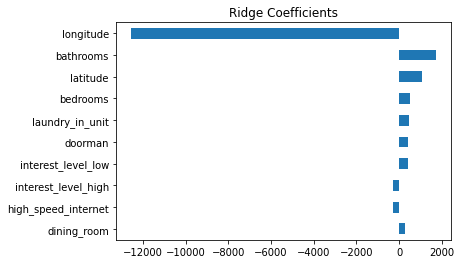

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

In [237]:
# Create your variables for coefficients 

coefficients = model_lr.coef_
features = ohe.get_feature_names()

feature_importance = pd.Series(coefficients, index= features).sort_values(key=abs)
print(feature_importance)

GROSS SQUARE FEET                         1.679609e+02
YEAR BUILT                                7.245298e+02
NEIGHBORHOOD_ROSSVILLE-RICHMOND VALLEY    1.324505e+14
NEIGHBORHOOD_HAMMELS                      1.324505e+14
NEIGHBORHOOD_DONGAN HILLS-OLD TOWN        1.324505e+14
                                              ...     
NEIGHBORHOOD_INWOOD                       3.642390e+15
BOROUGH_2.0                               7.049786e+15
BOROUGH_5.0                               7.152328e+15
BOROUGH_4.0                               7.152328e+15
BOROUGH_3.0                               7.925723e+15
Length: 185, dtype: float64


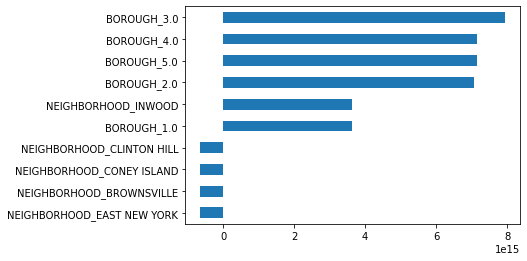

In [238]:
# Visualize the difference 

feature_importance.tail(10).plot(kind='barh');